### Setup: Change data here 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('/Users/starsrain/2025_concord/yieldCurve_augmenting/raw_data/data_1021-v1.csv')

### Yield Curve with days since origination 

1. Only regular payments (iPaymentMode=144), excluding arrangements and 3rd party
2. Filter out all loans having DueDate > Today
3. Payin Ratio = sum of paidoffamount / sum of originatedamount (for each freq, each month)

In [2]:
def compute_daily_yield(data):
    """
    Compute daily cumulative yield correctly:
    1. Get unique loans and their original amounts (avoid double counting)
    2. For each day since origination, sum all payments made up to that day
    3. Calculate yield as cumulative_payments / total_originated_amount
    """
    if data.empty:
        return pd.Series(dtype=float)
    
    # Get unique loans and their amounts (avoid double counting from multiple installments)
    loan_amounts = data.groupby('LoanID')['OriginatedAmount'].first()
    total_originated = loan_amounts.sum()
    
    # Group by Days_Since_Orig and sum payments for each day
    daily_payments = data.groupby('Days_Since_Orig')['PaidOffPaymentAmount'].sum()
    
    # Create cumulative sum of payments
    cumulative_payments = daily_payments.cumsum()
    
    # Calculate yield as cumulative payments / total originated
    yield_curve = cumulative_payments / total_originated
    
    return yield_curve

def prepare_df_strict(df):
    """Prepare dataframe with strict data cleaning"""
    df = df.copy()
    df = df[df['PaymentStatus'] != 'R']
    # Convert date columns
    date_cols = ['OriginationDate', 'DueDate']
    for col in date_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
    
    # Drop rows with missing critical fields
    critical_fields = ['LoanID', 'OriginatedAmount', 'InstallmentNumber']
    initial_count = len(df)
    df = df.dropna(subset=critical_fields)
    dropped = initial_count - len(df)
    if dropped > 0:
        print(f"[prepare] Dropped {dropped} rows with missing critical fields")

    
    # Create cohort from origination date
    df['Cohort'] = df['OriginationDate'].dt.to_period('M').astype(str)
    
    # Ensure CustType exists
    if 'CustType' not in df.columns:
        df['CustType'] = 'Unknown'
    before_dedup = len(df)
    df = df.drop_duplicates(subset=['LoanID', 'InstallmentNumber', 'DueDate', 'PaidOffPaymentAmount'])
    after_dedup = len(df)
    if before_dedup != after_dedup:
        print(f"[prepare] Removed {before_dedup - after_dedup} duplicate records")

    
    return df

# Updated plotting function with proper data cleaning and filtering
def plot_frequency_yield_curves_corrected(data, months, max_days=200, annotate_days=None):
    """
    Plot yield curves with correct filtering and calculation:
    1. Apply proper data cleaning (remove 'R' status, deduplicate, etc.)
    2. Filter DueDate <= today
    3. Group by frequency and origination month  
    4. Calculate daily yield correctly
    """
    
    if annotate_days is None:
        annotate_days = [30, 60, 90, 120, 150, 180]
    
    # Step 1: Apply proper data cleaning using existing function
    print("Step 1: Cleaning data...")
    df_cleaned = prepare_df_strict(data)
    
    # Step 2: Filter out loans with DueDate > today
    today = pd.Timestamp.now().normalize()
    print(f"Step 2: Filtering DueDate <= {today.date()}")
    
    initial_count = len(df_cleaned)
    df_filtered = df_cleaned[df_cleaned['DueDate'] <= today].copy()
    print(f"Kept {len(df_filtered):,}/{initial_count:,} records with DueDate <= today")
    
    # Step 3: Filter to requested origination months
    df_filtered = df_filtered[df_filtered['Cohort'].isin(months)]
    
    # Step 4: Remove any rows with missing critical data for yield calculation
    df_filtered = df_filtered.dropna(subset=['LoanID', 'OriginatedAmount', 'PaidOffPaymentAmount', 'Days_Since_Orig', 'Frequency'])
    
    print(f"Final dataset: {len(df_filtered):,} records, {df_filtered['LoanID'].nunique():,} unique loans")
    
    # Define frequency groups
    freq_groups = {
        'Weekly': ['W'],
        'Biweekly': ['B'],
        'Monthly_Benefits': ['MB'],
        'Monthly_Expenses': ['ME']
    }
    
    fig, axes = plt.subplots(1, len(freq_groups), figsize=(6*len(freq_groups), 6), sharey=True)
    if len(freq_groups) == 1:
        axes = [axes]
    
    # Colors for months
    palette = plt.get_cmap('tab10')
    month_colors = {m: palette(i % 10) for i, m in enumerate(months)}
    
    curves = {}
    
    print(f"\nYield Curves for months: {', '.join(months)}")
    print('='*80)
    
    for ax, (freq_name, freq_codes) in zip(axes, freq_groups.items()):
        ax.set_title(f"{freq_name} Loans", fontsize=14, fontweight='bold')
        ax.set_xlabel('Days Since Origination')
        ax.grid(True, alpha=0.3)
        
        freq_has_data = False
        
        for month in months:
            # Filter for this month and frequency
            subset = df_filtered[
                (df_filtered['Cohort'] == month) & 
                (df_filtered['Frequency'].isin(freq_codes))
            ].copy()
            
            if subset.empty:
                continue
                
            loan_count = subset['LoanID'].nunique()
            freq_has_data = True
            
            # Calculate yield curve
            curve = compute_daily_yield(subset)
            curves.setdefault(month, {})[freq_name] = curve.copy()
            
            # Plot curve
            ax.plot(curve.index, curve.values, 
                   label=f"{month} (n={loan_count:,})", 
                   color=month_colors[month], linewidth=2)
            for d in annotate_days:
                if d in curve.index:
                    ax.text(d, curve[d], f"{curve[d]:.2f}", 
                           fontsize=8, color=month_colors[month], 
                           ha='center', va='bottom')
            
            # Print summary
            summary_vals = []
            for d in annotate_days:
                if d in curve.index:
                    summary_vals.append(f"{d}d={curve[d]:.3f}")
            print(f"  {freq_name:17s} | {month} | loans={loan_count:,} | " + ', '.join(summary_vals))
        
        if not freq_has_data:
            ax.text(0.5, 0.5, 'No Data', transform=ax.transAxes, 
                   ha='center', va='center', fontsize=12, color='gray')
        
        # Format axes
        ax.axhline(1.0, color='red', linestyle='--', alpha=0.5, label='Target = 1.0')
        ax.set_xlim(0, max_days)
        ax.set_ylim(0, 1.8)
        ax.set_yticks(np.arange(0, 1.9, 0.1))
        ax.legend(fontsize=10, loc='lower right')
    
    axes[0].set_ylabel('Cumulative Yield (Paid / Originated)')
    fig.suptitle('Corrected Cumulative Yield Curves by Frequency', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return curves


Step 1: Cleaning data...
[prepare] Removed 7600 duplicate records
Step 2: Filtering DueDate <= 2025-10-27
Kept 436,824/439,198 records with DueDate <= today
Final dataset: 18,572 records, 4,469 unique loans

Yield Curves for months: 2025-05
  Weekly            | 2025-05 | loans=591 | 30d=0.656, 60d=1.092, 90d=1.277, 120d=1.365, 150d=1.401
  Biweekly          | 2025-05 | loans=3,239 | 30d=0.614, 60d=0.951, 90d=1.200, 120d=1.361, 150d=1.453
  Monthly_Benefits  | 2025-05 | loans=353 | 30d=0.588, 60d=0.926, 90d=1.170, 120d=1.325, 150d=1.466
  Monthly_Expenses  | 2025-05 | loans=286 | 30d=0.598, 60d=0.963, 90d=1.160, 120d=1.313, 150d=1.446


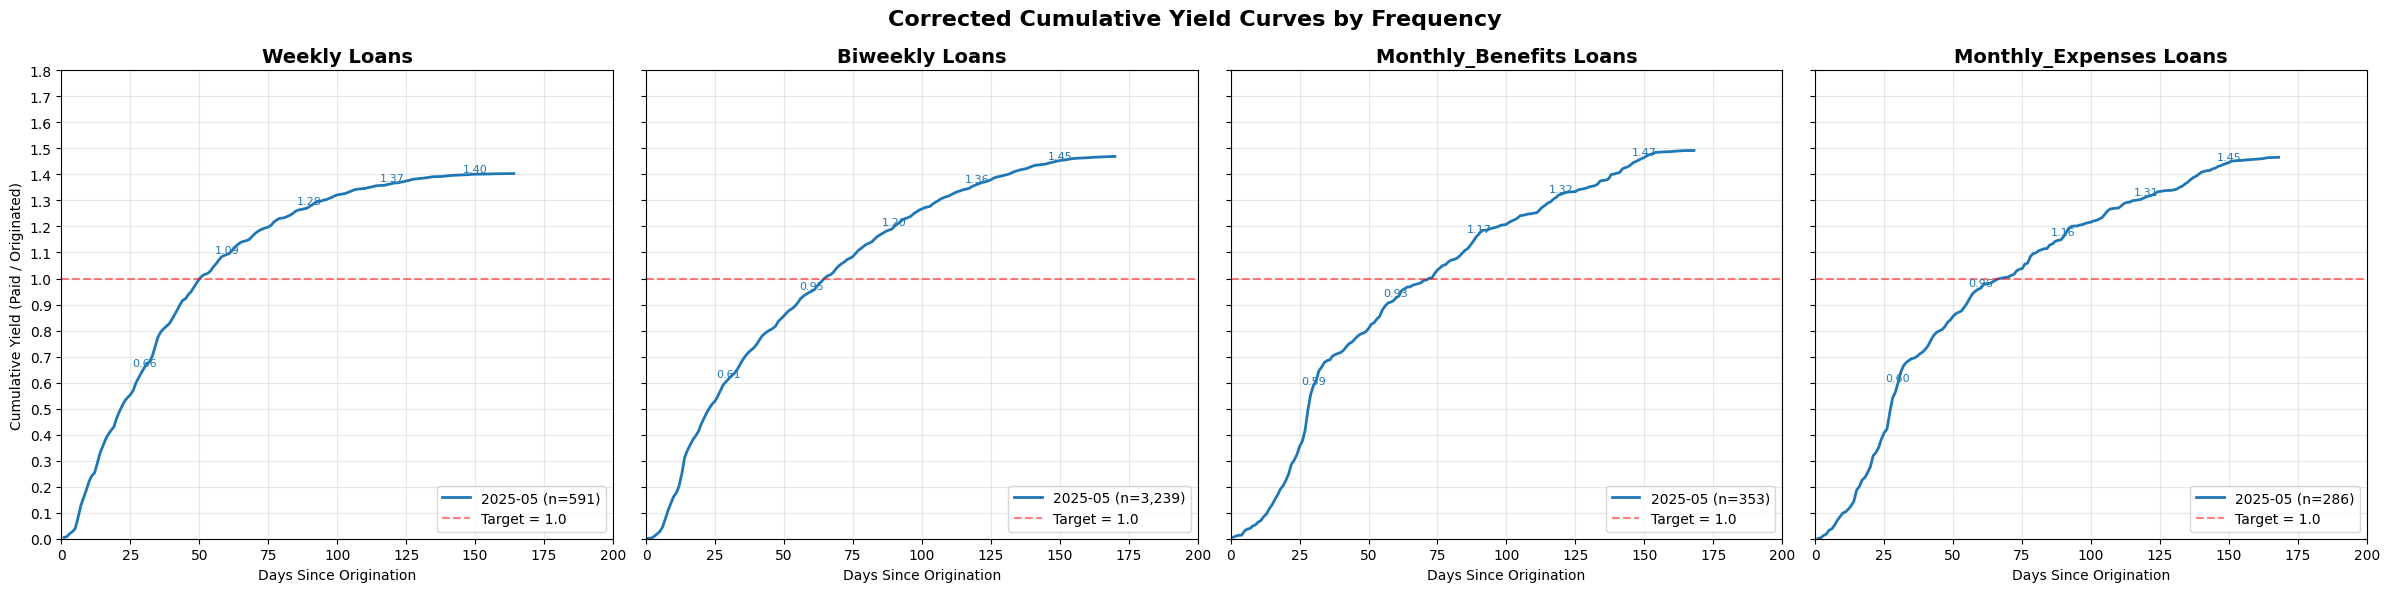

In [3]:
jan_curves_corrected = plot_frequency_yield_curves_corrected(df, months=['2025-05'])

### Yield Curve with InstallmentNumber

In [4]:
def create_payin_plots_by_frequency_all_data(df, cohorts, cap=1.70):
    """
    Create payin plots by InstallmentNumber for different loan frequencies
    - Apply proper data cleaning (remove 'R' status, deduplicate, etc.)
    - Filter out loans with DueDate > today
    - Separate plots for Weekly, Biweekly, and Monthly (MB+ME combined)
    - NON-CUMULATIVE: Shows payin ratio for each individual installment
    """
    
    # Step 1: Apply proper data cleaning
    print("Step 1: Cleaning data...")
    df_prepared = prepare_df_strict(df)
    
    # Step 2: Filter out loans with DueDate > today
    today = pd.Timestamp.now().normalize()
    print(f"Step 2: Filtering DueDate <= {today.date()}")
    
    initial_count = len(df_prepared)
    df_filtered = df_prepared[df_prepared['DueDate'] <= today].copy()
    print(f"Kept {len(df_filtered):,}/{initial_count:,} records with DueDate <= today")
    
    # Step 3: Filter to requested cohorts
    df_filtered = df_filtered[df_filtered['Cohort'].isin(cohorts)]
    print(f"Final dataset for cohorts {cohorts}: {len(df_filtered):,} records, {df_filtered['LoanID'].nunique():,} unique loans")
    
    frequency_mappings = {
        'Weekly': ['W'],
        'Biweekly': ['B'], 
        'Monthly': ['MB', 'ME']  
    }
    

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    cohort_colors = {
        '2025-06': 'blue',
        '2025-07': 'red',
        '2025-08': 'green',
        '2025-09': 'orange',
        '2025-10': 'purple'
    }
    
    for idx, (plot_title, freq_types) in enumerate(frequency_mappings.items()):
        ax = axes[idx]
        verticals = []
        
        for cohort in cohorts:
            # Filter data for this cohort and frequency types (using cleaned and filtered data)
            cohort_data = df_filtered[df_filtered['Cohort'] == cohort].copy()
            cohort_data = cohort_data[cohort_data['Frequency'].isin(freq_types)]
            
            if cohort_data.empty:
                continue
                
            # Calculate payin curve by installment
            loan_count = cohort_data['LoanID'].nunique()
            
            # Aggregate payments by loan and installment
            per_installment = (cohort_data.groupby(['LoanID', 'InstallmentNumber'], as_index=False)
                             .agg(PaidThisInstallment=('PaidOffPaymentAmount', 'sum'),
                                  OriginatedAmount=('OriginatedAmount', 'first')))
            
            # Calculate NON-CUMULATIVE payin ratio (payment for this installment only)
            per_installment['InstallmentPayinRatio'] = (per_installment['PaidThisInstallment'] / per_installment['OriginatedAmount']).clip(upper=cap)
            
            # Calculate weighted average payin ratio by installment (NON-CUMULATIVE) — no groupby.apply
            tmp_w = per_installment.assign(
                _w=per_installment['OriginatedAmount'],
                _wv=per_installment['InstallmentPayinRatio'] * per_installment['OriginatedAmount']
            )
            installment_curve = (tmp_w.groupby('InstallmentNumber', as_index=False)
                                   .agg(_wv_sum=('_wv','sum'), _w_sum=('_w','sum')))
            installment_curve['PayinRatio'] = installment_curve['_wv_sum'] / installment_curve['_w_sum']
            installment_curve = installment_curve[['InstallmentNumber','PayinRatio']]
            
            # Sort by installment number
            installment_curve = installment_curve.sort_values('InstallmentNumber').reset_index(drop=True)
            
            # Plot the curve
            color = cohort_colors.get(cohort, 'black')
            ax.plot(installment_curve['InstallmentNumber'], installment_curve['PayinRatio'],
                   color=color, linewidth=2, marker='o', markersize=4,
                   label=f'{cohort} (n={loan_count:,})', alpha=0.8)

            # Per-cohort Kmax stats (mean and IQR) for this frequency panel
            kmax_by_loan = (cohort_data.groupby('LoanID')['InstallmentNumber'].max())
            if not kmax_by_loan.empty:
                vals = kmax_by_loan.values.astype(float)
                avg_kmax = float(np.mean(vals))
                p25, med, p75 = np.percentile(vals, [25, 50, 75])
                verticals.append((avg_kmax, p25, med, p75, color, cohort))
        
        # Set different x-axis limits based on frequency
        if plot_title == 'Weekly':
            max_installment = 24  # Weekly loans have more installments
        elif plot_title == 'Biweekly':
            max_installment = 18  # Biweekly loans have moderate installments
        else:  # Monthly
            max_installment = 12  # Monthly loans have fewer installments
        
        # Formatting for each subplot
        ax.set_xlabel('Installment Number', fontsize=12)
        ax.set_ylabel('Installment Payin Ratio', fontsize=12)  # Changed label
        ax.set_title(f'{plot_title} Loans\nPayin by Installment (Non-Cumulative)', 
                    fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, max_installment)
        ax.set_ylim(0.0, cap + 0.1)

        # Per-cohort Kmax indicators: IQR band, median line, mean marker (match curve color)
        if verticals:
            y0, y1 = ax.get_ylim(); h = (y1 - y0)
            for avg_x, p25, med, p75, col, cohort in verticals:
                # IQR band
                ax.axvspan(p25, p75, color=col, alpha=0.08)
                # median: replace full-height line with a small top tick and legend proxy
                ax.plot([], [], color=col, linestyle='--', label=f'{cohort} Kmax P25/P50/P75 ≈ {p25:.1f}/{med:.1f}/{p75:.1f}')
                ax.plot([med-0.2, med+0.2], [y1 - 0.02*h, y1 - 0.02*h], color=col, lw=1.2, alpha=0.9)
                # mean baseline marker
                ax.scatter([avg_x], [y0 + 0.015*h], marker='v', s=30, color=col, zorder=5)
                ax.text(avg_x, y0 + 0.06*h, f'avg {avg_x:.1f}', color=col, ha='center', va='bottom', fontsize=8)

        # Add target line (typically much lower for individual installments)
        expected_installment_ratio = 1.0 / max_installment  # Rough expected per-installment ratio
        ax.axhline(y=expected_installment_ratio, color='red', linestyle='--', alpha=0.5, 
                  label=f'Expected ≈{expected_installment_ratio:.2f}')
        
        # Set x-axis ticks based on frequency
        if plot_title == 'Weekly':
            ax.set_xticks(range(0, max_installment + 1, 4))  # Every 4 weeks
        elif plot_title == 'Biweekly':
            ax.set_xticks(range(0, max_installment + 1, 3))  # Every 3 periods
        else:  # Monthly
            ax.set_xticks(range(0, max_installment + 1, 2))  # Every 2 months
        
        # Legend
        ax.legend(fontsize=10, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Print enhanced summary statistics (keeping cumulative stats for summary)
    print("PAYIN SUMMARY BY LOAN FREQUENCY (All Cohort Data)")
    print("="*80)
    
    for plot_title, freq_types in frequency_mappings.items():
        print(f"\n{plot_title} Loans:")
        print("-" * 50)
        
        for cohort in cohorts:
            cohort_data = df_filtered[df_filtered['Cohort'] == cohort].copy()
            cohort_data = cohort_data[cohort_data['Frequency'].isin(freq_types)]
            
            if not cohort_data.empty:
                # Calculate correct loan-level metrics first
                loan_level_data = cohort_data.groupby('LoanID').agg(
                    OriginatedAmount=('OriginatedAmount', 'first'),
                    TotalPaid=('PaidOffPaymentAmount', 'sum')
                ).reset_index()
                
                loan_count = len(loan_level_data)
                total_orig = loan_level_data['OriginatedAmount'].sum()
                total_paid = loan_level_data['TotalPaid'].sum()
                avg_orig = total_orig / loan_count if loan_count > 0 else 0
                
                # Show cohort overview
                print(f"\n  {cohort} Overview:")
                print(f"    Total Loans: {loan_count:,}")
                print(f"    Total Originated: ${total_orig/1000000:.2f}M")
                print(f"    Total Paid: ${total_paid/1000000:.2f}M")
                print(f"    Avg Loan Size: ${avg_orig:,.0f}")
                print(f"    Overall Payin Rate: {total_paid/total_orig:.1%}")
                
                # Show data range info
                if 'DueDate' in cohort_data.columns:
                    min_due_date = cohort_data['DueDate'].min()
                    max_due_date = cohort_data['DueDate'].max()
                    print(f"    Due dates: {min_due_date.strftime('%Y-%m-%d')} to {max_due_date.strftime('%Y-%m-%d')}")
                
                # Calculate detailed installment statistics
                per_installment = (cohort_data.groupby(['LoanID', 'InstallmentNumber'], as_index=False)
                                 .agg(PaidThisInstallment=('PaidOffPaymentAmount', 'sum'),
                                      OriginatedAmount=('OriginatedAmount', 'first')))
                
                per_installment = per_installment.sort_values(['LoanID', 'InstallmentNumber'])
                per_installment['CumPaid'] = per_installment.groupby('LoanID')['PaidThisInstallment'].cumsum()
                per_installment['PayinRatio'] = (per_installment['CumPaid'] / per_installment['OriginatedAmount']).clip(upper=cap)
                
                # Get the correct total originated amount (same for all installments)
                total_cohort_orig = loan_level_data['OriginatedAmount'].sum()
                
                # Installment-level statistics with corrected calculations
                installment_stats = per_installment.groupby('InstallmentNumber').agg(
                    loan_count=('LoanID', 'nunique'),
                    total_paid_at_inst=('PaidThisInstallment', 'sum'),  # Payments made IN this installment
                    weighted_payin=('PayinRatio', lambda x: np.average(x, weights=per_installment.loc[x.index, 'OriginatedAmount']))
                ).reset_index()
                
                # Calculate cumulative paid correctly across all loans in cohort
                installment_stats = installment_stats.sort_values('InstallmentNumber')
                installment_stats['cum_total_paid'] = installment_stats['total_paid_at_inst'].cumsum()
                
                # Add total originated amount (same for all installments for this cohort)
                installment_stats['total_orig_at_inst'] = total_cohort_orig
                
                # Show payin at key installments with enhanced details
                if plot_title == 'Weekly':
                    key_installments = [1, 2, 3, 4, 5, 6, 12, 24]  # 2, 4, 6, 12, 24 weeks
                elif plot_title == 'Biweekly':
                    key_installments = [1, 2, 3, 6, 12]   # 1, 2, 3, 6, 12 biweekly periods
                else:  # Monthly
                    key_installments = [1, 2, 3, 6, 12]   # 1, 2, 3, 6, 12 months
                
                print(f"\n    Installment Details:")
                print(f"    {'Inst':>4} {'Loans':>6} {'Orig($M)':>8} {'Paid($M)':>8} {'CumPaid($M)':>10} {'PayinRate':>9}")
                print(f"    {'-'*4} {'-'*6} {'-'*8} {'-'*8} {'-'*10} {'-'*9}")
                
                for inst in key_installments:
                    inst_stats = installment_stats[installment_stats['InstallmentNumber'] == inst]
                    if not inst_stats.empty:
                        row = inst_stats.iloc[0]
                        print(f"    {int(inst):4d} {int(row['loan_count']):6,} "
                              f"{row['total_orig_at_inst']/1000000:8.2f} "
                              f"{row['total_paid_at_inst']/1000000:8.2f} "
                              f"{row['cum_total_paid']/1000000:10.2f} "
                              f"{row['weighted_payin']:9.3f}")

Step 1: Cleaning data...
[prepare] Removed 7600 duplicate records
Step 2: Filtering DueDate <= 2025-10-27
Kept 436,824/439,198 records with DueDate <= today
Final dataset for cohorts ['2025-08', '2025-09']: 16,783 records, 7,160 unique loans


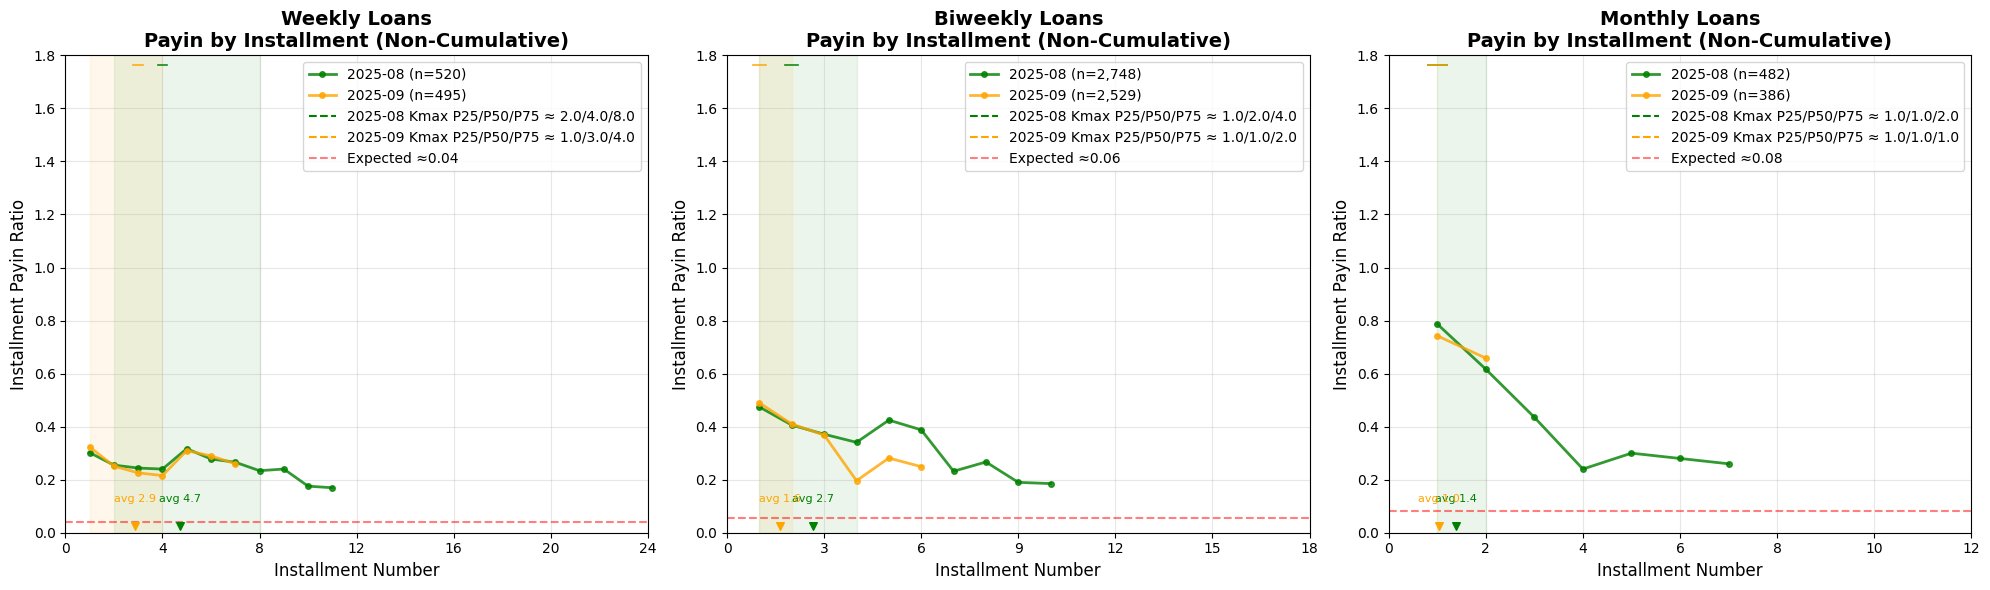

PAYIN SUMMARY BY LOAN FREQUENCY (All Cohort Data)

Weekly Loans:
--------------------------------------------------

  2025-08 Overview:
    Total Loans: 520
    Total Originated: $0.44M
    Total Paid: $0.53M
    Avg Loan Size: $847
    Overall Payin Rate: 121.2%
    Due dates: 2025-08-05 to 2025-10-24

    Installment Details:
    Inst  Loans Orig($M) Paid($M) CumPaid($M) PayinRate
    ---- ------ -------- -------- ---------- ---------
       1    469     0.44     0.13       0.13     0.302
       2    398     0.44     0.09       0.21     0.414
       3    325     0.44     0.07       0.28     0.603
       4    282     0.44     0.06       0.34     0.793
       5    240     0.44     0.06       0.40     1.063
       6    207     0.44     0.05       0.45     1.282

  2025-09 Overview:
    Total Loans: 495
    Total Originated: $0.39M
    Total Paid: $0.29M
    Avg Loan Size: $788
    Overall Payin Rate: 74.7%
    Due dates: 2025-09-05 to 2025-10-24

    Installment Details:
    Inst  Loan

In [5]:
create_payin_plots_by_frequency_all_data(df, cohorts=["2025-08", "2025-09"], cap=1.70)

Testing installment-based payin with January 2025 data...
Step 1: Cleaning data...
[prepare] Removed 7600 duplicate records
Step 2: Filtering DueDate <= 2025-10-27
Kept 436,824/439,198 records with DueDate <= today
Final dataset for cohorts ['2025-01']: 21,281 records, 4,400 unique loans


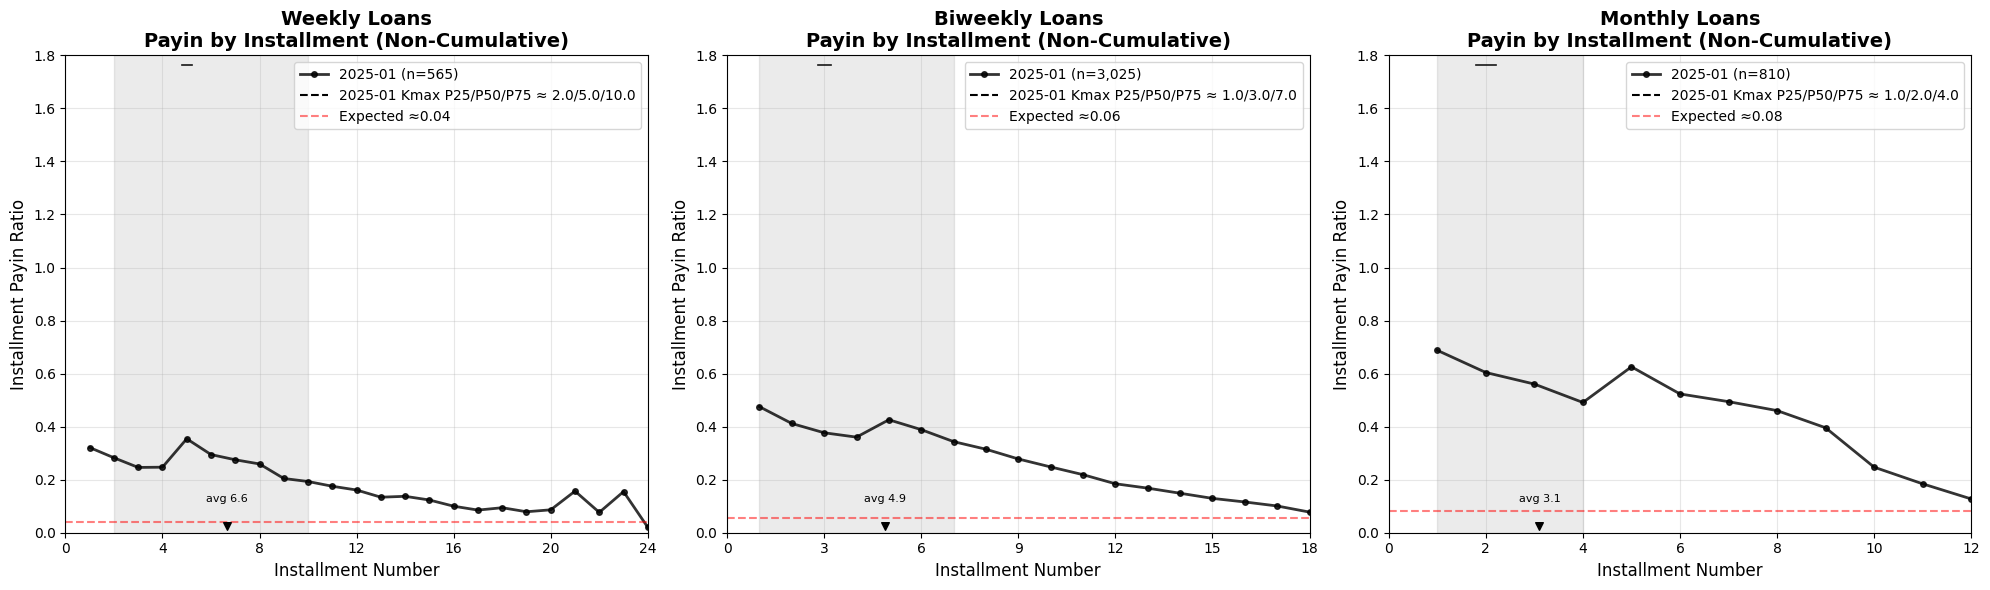

PAYIN SUMMARY BY LOAN FREQUENCY (All Cohort Data)

Weekly Loans:
--------------------------------------------------

  2025-01 Overview:
    Total Loans: 565
    Total Originated: $0.45M
    Total Paid: $0.70M
    Avg Loan Size: $788
    Overall Payin Rate: 157.1%
    Due dates: 2025-01-08 to 2025-10-16

    Installment Details:
    Inst  Loans Orig($M) Paid($M) CumPaid($M) PayinRate
    ---- ------ -------- -------- ---------- ---------
       1    502     0.45     0.13       0.13     0.321
       2    441     0.45     0.10       0.23     0.458
       3    383     0.45     0.07       0.30     0.636
       4    340     0.45     0.06       0.37     0.827
       5    292     0.45     0.08       0.44     1.104
       6    249     0.45     0.05       0.50     1.322
      12    115     0.45     0.01       0.66     1.696
      24      2     0.45     0.00       0.70     1.700

Biweekly Loans:
--------------------------------------------------

  2025-01 Overview:
    Total Loans: 3,025
    To

In [6]:
# Test with January data to compare with the yield curve
print("=" * 80)
print("Testing installment-based payin with January 2025 data...")
create_payin_plots_by_frequency_all_data(df, cohorts=["2025-01"], cap=1.70)

## Ad-hoc monthly sanity check

In [10]:
df.head(5)

,Application_ID,PortFolioID,LoanID,Frequency,LPCampaign,OriginatedAmount,OrigYear,OrigMonth,OrigWeek,OriginationDate,...,TransactionDate,PmtYear,PmtMonth,Days_Since_Orig,Weeks_Since_Orig,PaymentType,Payment_Number,PaymentStatus,weeks_between_orig_now,CustType
0,99678497,6,I1912769-0,B,RTRNGD,400.0,2024.0,1.0,1.0,2024-01-01 03:15:29.720,...,2024-01-05 07:34:30.210,2024.0,1.0,4.0,1.0,Installment Pmt,2,R,94.0,REPEAT
1,99678497,6,I1912769-0,B,RTRNGD,400.0,2024.0,1.0,1.0,2024-01-01 03:15:29.720,...,2024-01-05 08:11:13.350,2024.0,1.0,4.0,1.0,Installment Pmt,1,D,94.0,REPEAT
2,99678497,6,I1912769-0,B,RTRNGD,400.0,2024.0,1.0,1.0,2024-01-01 03:15:29.720,...,2024-01-17 14:12:23.833,2024.0,1.0,16.0,3.0,Installment Pmt,3,D,94.0,REPEAT
3,99678497,6,I1912769-0,B,RTRNGD,400.0,2024.0,1.0,1.0,2024-01-01 03:15:29.720,...,2024-02-02 07:14:24.553,2024.0,2.0,32.0,5.0,Installment Pmt,4,D,94.0,REPEAT
4,99678497,6,I1912769-0,B,RTRNGD,400.0,2024.0,1.0,1.0,2024-01-01 03:15:29.720,...,2024-02-16 07:45:37.937,2024.0,2.0,46.0,7.0,Installment Pmt,5,D,94.0,REPEAT


In [13]:
df_sep = prepare_df_strict(df)

[prepare] Removed 7600 duplicate records


In [14]:
df_sep.columns

Index(['Application_ID', 'PortFolioID', 'LoanID', 'Frequency', 'LPCampaign',
       'OriginatedAmount', 'OrigYear', 'OrigMonth', 'OrigWeek',
       'OriginationDate', 'FPDFA', 'FPDAA', 'TotalRealizedPayin',
       'InstallmentNumber', 'PaidOffPaymentAmount', 'DueDate',
       'TransactionDate', 'PmtYear', 'PmtMonth', 'Days_Since_Orig',
       'Weeks_Since_Orig', 'PaymentType', 'Payment_Number', 'PaymentStatus',
       'weeks_between_orig_now', 'CustType', 'Cohort'],
      dtype='object')

In [15]:
# Cohort definition from your earlier logic
mask = (
    (df_sep["Cohort"] == "2025-09") &
    (df_sep["Frequency"].isin(["MB", "ME"])) &          # monthly frequencies
    (pd.to_datetime(df["DueDate"]) <= pd.Timestamp.today())
)

monthly_sep = df_sep.loc[mask].copy()
print(len(monthly_sep), "installment records")
print(monthly_sep["LoanID"].nunique(), "unique loans")


437 installment records
386 unique loans


In [16]:
import numpy as np
summary = (
    monthly_sep.groupby("LoanID", as_index=False)
    .agg(
        OriginatedAmount=("OriginatedAmount", "first"),
        TotalPaid=("PaidOffPaymentAmount", "sum")
    )
)
summary["PayinRate"] = summary["TotalPaid"] / summary["OriginatedAmount"]
print(summary["OriginatedAmount"].sum()/1e6, "M originated")
print(summary["TotalPaid"].sum()/1e6, "M paid")
print(summary["PayinRate"].mean(), "avg pay-in rate")

sample_loans = np.random.choice(summary["LoanID"], size=5, replace=False)
check = monthly_sep[monthly_sep["LoanID"].isin(sample_loans)].sort_values(
    ["LoanID", "InstallmentNumber"]
)

check[[
    "LoanID", "InstallmentNumber", "DueDate",
    "PaidOffPaymentAmount", "OriginatedAmount",
    "Days_Since_Orig", "PaymentStatus"
]].head(30)


0.27905 M originated
0.21447311 M paid
0.7913896902987899 avg pay-in rate


,LoanID,InstallmentNumber,DueDate,PaidOffPaymentAmount,OriginatedAmount,Days_Since_Orig,PaymentStatus
760176,I2433999-0,1,2025-09-26,175.00,400.0,22.0,D
760177,I2433999-0,1,2025-09-26,22.92,400.0,24.0,D
760178,I2433999-0,2,2025-10-27,293.95,400.0,44.0,D
763630,I2437152-0,1,2025-10-01,500.00,500.0,19.0,D
764869,I2439029-0,1,2025-10-08,35.00,400.0,23.0,D
767249,I2443899-0,1,2025-10-03,150.00,500.0,8.0,D
768389,I2446929-0,1,2025-10-10,275.00,600.0,10.0,D
